In [2]:
import os
import cv2
import numpy as np
import glob

# Import of Metavision Machine Learning binding
import metavision_sdk_ml
import metavision_sdk_cv
from metavision_sdk_core import EventBbox
from metavision_sdk_core import BaseFrameGenerationAlgorithm
from metavision_core.event_io.py_reader import EventDatReader
from metavision_core.event_io.events_iterator import EventsIterator
from metavision_core.event_io import EventNpyReader

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [11, 7]

[[  0   0 255]
 [  0 170 255]
 [  0 255 170]
 [  0 255   0]
 [170 255   0]
 [255 170   0]
 [255   0   0]
 [255   0 170]]


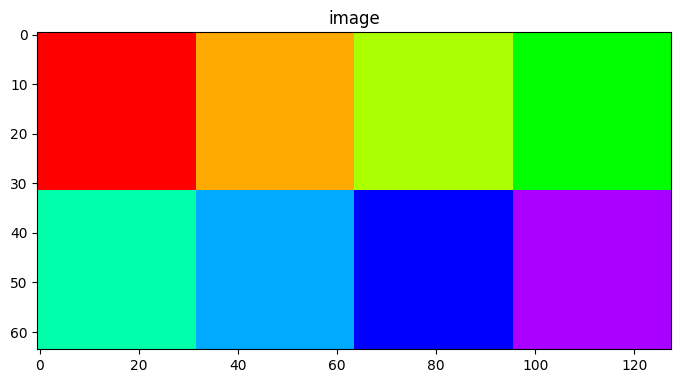

In [2]:
colors_hsv = np.uint8([[[0,255,255], [20,255,255], [40,255,255], [60,255,255], [80,255,255], [100,255,255], [120,255,255], [140,255,255]]])
colors_bgr = cv2.cvtColor(colors_hsv, cv2.COLOR_HSV2BGR).squeeze()
print(colors_bgr)
block_num = len(colors_bgr)
cols = 4
rows = int(np.ceil(block_num / cols))
image = np.zeros([32*rows, 32*cols, 3], dtype=np.uint8)

for i, bgr in enumerate(colors_bgr):
    r = i // cols
    c = i % cols
    image[r*32:(r+1)*32, c*32:(c+1)*32, :] = bgr

# Plot result
plt.close('all')
row = 1
col = 2

plt.subplot(row,col,1)
plt.title('image')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.gcf().set_size_inches(18, 6*row)
plt.show()

In [3]:
def nms(box_events, scores, iou_thresh=0.5):
    """NMS on box_events

    Args:
        box_events (np.ndarray): nx1 with dtype EventBbox, the sorting order of those box is used as a
            a criterion for the nms.
        scores (np.ndarray): nx1 dtype of plain dtype, needs to be argsortable.
        iou_thresh (float): if two boxes overlap with more than `iou_thresh` (intersection over union threshold)
            with each other, only the one with the highest criterion value is kept.

    Returns:
        keep (np.ndarray): Indices of the box to keep in the input array.
    """
    x1 = box_events['x']
    y1 = box_events['y']
    x2 = box_events['x'] + box_events['w']
    y2 = box_events['y'] + box_events['h']

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= iou_thresh)[0]
        order = order[inds + 1]

    return sorted(keep)

In [4]:
event_dat_dir = "/home/tkyen/opencv_practice/data_1/Gen1_Automotive/detection_dataset_duration_60s_ratio_1.0/test"
gt_label_dir = "/home/tkyen/opencv_practice/data_1/Gen1_Automotive/HMNet/test_lbl"
dt_label_dir = "/home/tkyen/opencv_practice/HMNet/experiments/detection/workspace/hmnet_B3_yolox/result/pred_test_10"
video_dir = dt_label_dir + "_video"
os.makedirs(video_dir, exist_ok=True)

event_dat_list = sorted(glob.glob(os.path.join(event_dat_dir, "*.dat")))
gt_label_list = sorted(glob.glob(os.path.join(gt_label_dir, "*.npy")))
dt_label_list = sorted(glob.glob(os.path.join(dt_label_dir, "*.npy")))
downsample = 0
selected_files = []

In [5]:
event_dat_dir = "/home/tkyen/opencv_practice/data_3/Gen1_Automotive/detection_dataset_duration_60s_ratio_1.0/test_aug"
gt_label_dir = "/home/tkyen/opencv_practice/data_1/Gen1_Automotive/HMNet_aug/test_lbl"
dt_label_dir = "/home/tkyen/opencv_practice/HMNet/experiments/detection/workspace/hmnet_B3_yolox_tbptt/result/pred_test_hmnet_aug"
video_dir = dt_label_dir + "_video"
os.makedirs(video_dir, exist_ok=True)

event_dat_list = sorted(glob.glob(os.path.join(event_dat_dir, "*.dat")))
gt_label_list = sorted(glob.glob(os.path.join(gt_label_dir, "*.npy")))
dt_label_list = sorted(glob.glob(os.path.join(dt_label_dir, "*.npy")))
downsample = 0
selected_files = []

In [6]:
event_dat_dir = "/home/tkyen/opencv_practice/data_3/Gen1_Automotive/Gen4to1/test_gen4to1_dat"
gt_label_dir = "/home/tkyen/opencv_practice/data_1/Gen1_Automotive/HMNet_Gen4to1/test_lbl"
dt_label_dir = "/home/tkyen/opencv_practice/HMNet/experiments/detection/workspace/hmnet_B3_yolox_tbptt/result/pred_test_gen4to1"
video_dir = dt_label_dir + "_video"
os.makedirs(video_dir, exist_ok=True)

event_dat_list = sorted(glob.glob(os.path.join(event_dat_dir, "*.dat")))
gt_label_list = sorted(glob.glob(os.path.join(gt_label_dir, "*.npy")))
dt_label_list = sorted(glob.glob(os.path.join(dt_label_dir, "*.npy")))
downsample = 0
selected_files = []

In [7]:
event_dat_dir = "/home/tkyen/opencv_practice/data_1/Gen4_Automotive/test_dat"
gt_label_dir = "/home/tkyen/opencv_practice/data_3/Gen4_Automotive_event_cube_paper/result_vanilla_ssd_level_5/evaluation_epoch_31/gt"
dt_label_dir = "/home/tkyen/opencv_practice/data_3/Gen4_Automotive_event_cube_paper/result_vanilla_ssd_level_5/evaluation_epoch_31/dt_SORT"
video_dir = dt_label_dir + "_video"
os.makedirs(video_dir, exist_ok=True)

event_dat_list = sorted(glob.glob(os.path.join(event_dat_dir, "*.dat")))
gt_label_list = sorted(glob.glob(os.path.join(gt_label_dir, "*.npy")))
dt_label_list = sorted(glob.glob(os.path.join(dt_label_dir, "*.npy")))
downsample = 1
selected_files = ["moorea_2019-02-19_001_td_1220500000_1280500000"]

event_dat_path = os.path.join(event_dat_dir, "moorea_2019-02-19_001_td_1220500000_1280500000_td.dat")
event_dat = EventDatReader(event_dat_path)
event_dat.seek_time(0)
ev_height, ev_width = event_dat.get_size()
if downsample > 0:
    ev_height = ev_height >> downsample
    ev_width = ev_width >> downsample
history = np.zeros((ev_height, ev_width), dtype=np.uint16)

gt_label_path = os.path.join(gt_label_dir, "moorea_2019-02-19_001_td_1220500000_1280500000_bbox.npy")
gt_label = EventNpyReader(gt_label_path)
gt_label.seek_time(0)

dt_label_path = os.path.join(dt_label_dir, "moorea_2019-02-19_001_td_1220500000_1280500000_bbox.npy")
dt_label = EventNpyReader(dt_label_path)
dt_label.seek_time(0)

delta_t = 100000
dt_boxes = dt_label.load_delta_t(delta_t=delta_t)
print(dt_boxes)

# for i in range(39050//50+1):
#     events = event_dat.load_delta_t(delta_t=delta_t)
#     gt_boxes = gt_label.load_delta_t(delta_t=delta_t)
#     if downsample > 0:
#         events['x'] = events['x'] >> downsample
#         events['y'] = events['y'] >> downsample
#     x = events['x']
#     y = events['y']
#     t = events['t'] // 1000 # us->ms
#     history[y, x] = t

[(    0, 357.10156 , 164.71014, 15.909363, 14.957336, 6, 1, 0.5294135 )
 (50000,  14.951805, 150.8563 ,  4.837986,  7.674103, 6, 2, 0.52339065)
 (50000, 362.78122 , 165.15112, 15.4472  , 15.39416 , 6, 1, 0.71449167)]


[(39050000,   0.     , 185.50732, 175.61494  , 125.6279   , 3, 3265, 0.998196)
 (39050000, 235.04968, 149.94768, 170.90057  , 138.48183  , 3, 3280, 0.997911)
 (39050000, 255.86389,   0.     ,  20.176788 ,   2.3970299, 7, 3286, 0.994216)
 (39050000, 406.623  ,  90.17247,  17.080109 ,  43.755814 , 7, 3324, 0.971232)
 (39050000, 243.74602, 123.47481,   6.6302185,  15.096558 , 7, 3319, 0.967987)
 (39050000, 418.89227, 169.08122,   7.2346497,  17.751068 , 7, 3333, 0.945341)
 (39050000, 271.60107, 122.27324,   6.745636 ,  14.516769 , 7, 3303, 0.925026)]
161 39096
(38935,) (38936,)


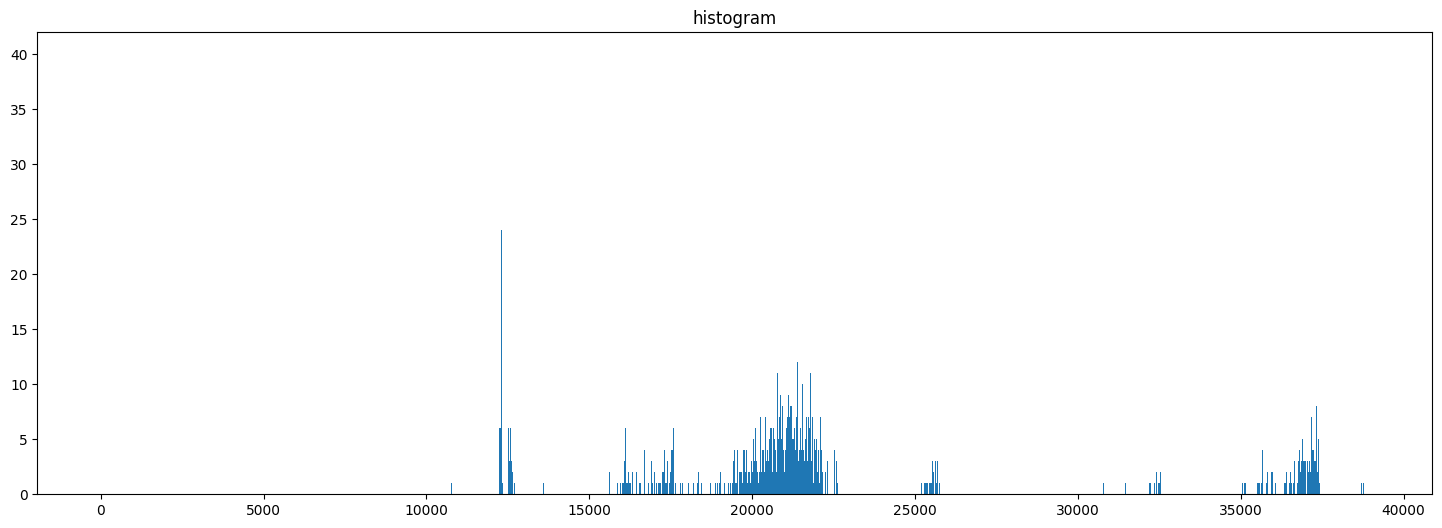

In [49]:
print(gt_boxes)
object = history[185:185+126, 0:0+176]
L = np.min(object[object>0])
H = np.max(object[object>0])
print(L, H)
H = H + 1
hist = np.histogram(object, bins=list(np.arange(L,H)))
y, x = hist
print(y.shape, x.shape)
# Plot result
plt.close('all')
row = 1
col = 1

plt.subplot(row,col,1)
plt.title('histogram')
plt.bar(np.arange(len(y)), y, width=1.0)

plt.gcf().set_size_inches(18, 6*row)
plt.show()


In [19]:
event_dat_dir = "/home/tkyen/opencv_practice/data_1/Gen4_Automotive/test_dat"
gt_label_dir = "/home/tkyen/opencv_practice/data_1/Gen4_Automotive/test_dat"
dt_label_dir = "/home/tkyen/opencv_practice/data_2/Gen4_Automotive_DMANet_tk/test_result"
video_dir = dt_label_dir + "_video"
os.makedirs(video_dir, exist_ok=True)

event_dat_list = [os.path.join(event_dat_dir, "moorea_2019-02-19_005_td_915500000_975500000_td.dat")]
gt_label_list = [os.path.join(gt_label_dir, "moorea_2019-02-19_005_td_915500000_975500000_bbox.npy")]
dt_label_list = [os.path.join(dt_label_dir, "moorea_2019-02-19_005_td_915500000_975500000_bbox.npy")]
downsample = 0
selected_files = ["moorea_2019-02-19_005_td_915500000_975500000"]

In [29]:
for i, (event_dat_path, gt_label_path, dt_label_path) in enumerate(zip(event_dat_list, gt_label_list, dt_label_list)):
    event_file = os.path.basename(event_dat_path).replace('_td.dat', '')
    gt_file = os.path.basename(gt_label_path).replace('_bbox.npy', '')
    dt_file = os.path.basename(dt_label_path).replace('_bbox.npy', '')
    assert event_file==gt_file==dt_file

    if len(selected_files) > 0:
        if event_file not in selected_files:
            continue

    event_dat = EventDatReader(event_dat_path)
    event_dat.seek_time(0)
    ev_height, ev_width = event_dat.get_size()
    if downsample > 0:
        ev_height = ev_height >> downsample
        ev_width = ev_width >> downsample

    gt_label = EventNpyReader(gt_label_path)
    gt_label.seek_time(0)

    dt_label = EventNpyReader(dt_label_path)
    dt_label.seek_time(0)

    delta_t = 50000

    # VideoWriter
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')
    frame_rate = 10
    video_writer = cv2.VideoWriter(os.path.join(video_dir, '{}.mp4'.format(event_file)), fourcc, frame_rate, (ev_width*2, ev_height))
    colors = colors_bgr.tolist()

    for i in range(int(60e6//delta_t)):
        events = event_dat.load_delta_t(delta_t=delta_t)
        gt_boxes = gt_label.load_delta_t(delta_t=delta_t)
        gt_boxes = gt_boxes[nms(gt_boxes, gt_boxes['class_confidence'], iou_thresh=0.5)]
        dt_boxes = dt_label.load_delta_t(delta_t=delta_t)
        dt_boxes = dt_boxes[nms(dt_boxes, dt_boxes['class_confidence'], iou_thresh=0.5)]

        if i == 0:
            print(gt_boxes.dtype)
            print(dt_boxes.dtype)

        if downsample > 0:
            events['x'] = events['x'] >> downsample
            events['y'] = events['y'] >> downsample

        if len(gt_boxes) > 0:
            assert gt_boxes['t'][0]>=delta_t*i and gt_boxes['t'][-1]<delta_t*(i+1)
        if len(dt_boxes) > 0:
            assert dt_boxes['t'][0]>=delta_t*i and dt_boxes['t'][-1]<delta_t*(i+1)

        image_all = np.zeros((ev_height, ev_width*2, 3), dtype=np.uint8)
        BaseFrameGenerationAlgorithm.generate_frame(events, image_all[:,:ev_width, :])
        image_all[:,ev_width:, :] = image_all[:,:ev_width, :].copy()
        cv2.putText(image_all, '{} ms / {} ms'.format(i*delta_t//1000, (i+1)*delta_t//1000), 
                    (ev_width-200, 20), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (0, 255, 255), 1, cv2.LINE_AA)
        cv2.putText(image_all, 'GT',
                    (10, 20), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (0, 255, 255), 1, cv2.LINE_AA)
        cv2.putText(image_all, 'DT',
                    (ev_width+10, 20), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (0, 255, 255), 1, cv2.LINE_AA)
        image_all = cv2.line(image_all, (ev_width,0), (ev_width,ev_height), (0,255,255), 1)

        for gt_box in gt_boxes:
            if len(gt_box) == 9:
                t, x, y, w, h, class_id, confidence, track_id, invalid = gt_box
                x, y, w, h = int(x), int(y), int(w), int(h)
                if invalid == False:
                    cv2.rectangle(image_all, (x, y), (x+w, y+h), colors[class_id], 1)
            else:
                t, x, y, w, h, class_id, track_id, confidence = gt_box
                x, y, w, h = int(x), int(y), int(w), int(h)
                cv2.rectangle(image_all, (x, y), (x+w, y+h), colors[class_id], 1)

        for dt_box in dt_boxes:
            # t, x, y, w, h, class_id, track_id, confidence = dt_box
            t, x, y, w, h, class_id, confidence, track_id = dt_box
            # print(t, x, y, w, h, class_id, confidence, track_id)
            if confidence > 0.2:
                x, y, w, h = int(x), int(y), int(w), int(h)
                cv2.putText(image_all, str(round(confidence, 3)), (ev_width+x, y-6), cv2.FONT_HERSHEY_TRIPLEX, 0.6, colors[class_id], 1, cv2.LINE_AA)
                cv2.rectangle(image_all, (ev_width+x, y), (ev_width+x+w, y+h), colors[class_id], 1)

        video_writer.write(image_all)
    video_writer.release()

[('t', '<u8'), ('x', '<f4'), ('y', '<f4'), ('w', '<f4'), ('h', '<f4'), ('class_id', 'u1'), ('class_confidence', '<f4'), ('track_id', '<u4')]
[('t', '<u8'), ('x', '<f4'), ('y', '<f4'), ('w', '<f4'), ('h', '<f4'), ('class_id', 'u1'), ('class_confidence', '<f4'), ('track_id', '<u4')]
